## ДЗ

#### 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов. 

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

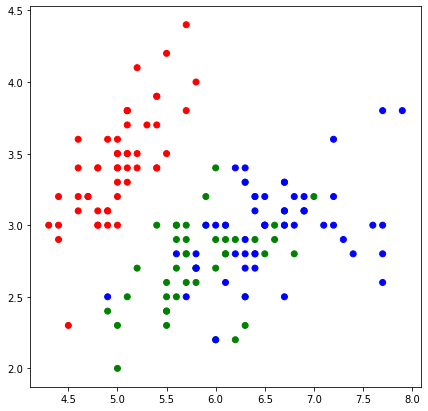

In [3]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [4]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

##### Добавляем веса $w(d) = q^{d}$,   $q \in (0,1)$;

In [5]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            distance = e_metrics(x, x_train[i])
            test_distances.append((distance, y_train[i]))
        
        w = {class_item: 0 for class_item in set(y_train)}
        q = 0.5
        for d in sorted(test_distances)[0:k]:
            w[d[1]] += q**d[0]
#         print(w)

#         print(sorted(w, key=w.get)[-1])    
        answers.append(sorted(w, key=w.get)[-1])
    return answers

In [6]:
classes= {class_item: 0 for class_item in set(y_train)}
print (classes)      
w = classes.copy() 
print(w)
print(w.get)

{0: 0, 1: 0, 2: 0}
{0: 0, 1: 0, 2: 0}
<built-in method get of dict object at 0x000001D3BE29A318>


In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [8]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [9]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.867


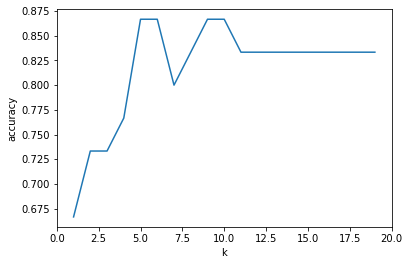

In [10]:
my_test_err = []
max_k = 20
for k_ in range(1, max_k):
    y_pred = knn(X_train, y_train, X_test, k_)
    my_test_err.append(accuracy(y_pred, y_test))

# строим график
plt.xlabel('k')
plt.ylabel('accuracy')
plt.xlim(0, max_k)
plt.plot(list(range(1, max_k)), my_test_err, label='test error')
plt.show()

#### 2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

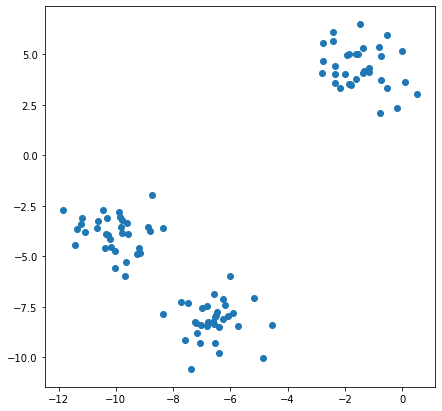

In [11]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [12]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [13]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
    
    plt.show()

#### Функция подсчета метрики качества кластеризации

In [14]:
def intraclass_mean_squared_distance(centroids, classes):
    
    imsd = []
    for k in classes.keys():
        dist = 0
        for point in classes[k]:
            dist += e_metrics(point, centroids[k])**2
        imsd.append(dist/len(classes[k]))
    return sum(imsd)

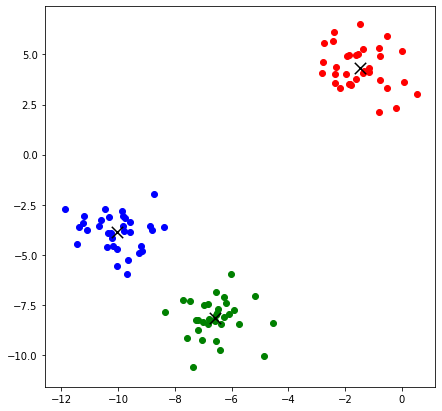

In [15]:
max_iterations = 5
min_distance = 1e-4
k = 3
centroids, clusters = kmeans(X, k, max_iterations, min_distance)
visualize(centroids, clusters)

#### Построить график зависимости метрики качества кластеризации от количества кластеров k (взять от 1 до 10)

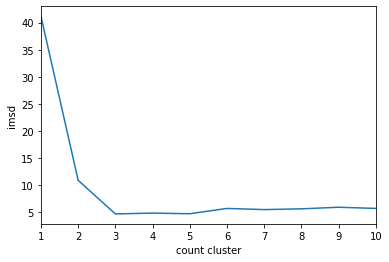

In [16]:
max_iterations = 20
min_distance = 1e-4

imsd =[]
max_k = 11
for k_ in range(1, max_k):
    centroids, clusters = kmeans(X, k_, max_iterations, min_distance)
    imsd.append(intraclass_mean_squared_distance(centroids, clusters))

# строим график
plt.xlabel('count cluster')
plt.ylabel('imsd')
plt.xlim(1, max_k-1)
plt.plot(list(range(1, max_k)), imsd)
plt.show()